<a href="https://colab.research.google.com/github/cocoisland/DS-Unit-4-Sprint-1-Tree-Ensembles/blob/master/thinking_blackbox.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install category_encoders

    100% |████████████████████████████████| 61kB 3.9MB/s 


In [0]:
import category_encoders as ce
import pandas as pd
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline

# Load data from https://www.kaggle.com/c/ds1-tree-ensembles/data
train_url="https://raw.githubusercontent.com/cocoisland/DS-Unit-4-Sprint-1-Tree-Ensembles/master/data/train_features.csv"
label_url="https://raw.githubusercontent.com/cocoisland/DS-Unit-4-Sprint-1-Tree-Ensembles/master/data/train_labels.csv"
test_url="https://raw.githubusercontent.com/cocoisland/DS-Unit-4-Sprint-1-Tree-Ensembles/master/data/test_features.csv"
submission_url="https://raw.githubusercontent.com/cocoisland/DS-Unit-4-Sprint-1-Tree-Ensembles/master/data/sample_submission.csv"
LCDataDictionary_url="https://raw.githubusercontent.com/cocoisland/DS-Unit-4-Sprint-1-Tree-Ensembles/master/data/LCDataDictionary.xlsx"

X_train = pd.read_csv(train_url)
y_train = pd.read_csv(label_url)['charged_off']
X_test = pd.read_csv(test_url)
df_submission = pd.read_csv(submission_url)
X_Dict = pd.read_excel(LCDataDictionary_url)

def wrangle(X):
    X = X.copy()
    
    # Drop some columns
    X = X.drop(columns='id')  # id is random
    X = X.drop(columns=['member_id', 'url', 'desc'])  # All null
    X = X.drop(columns='title')  # Duplicative of purpose
    X = X.drop(columns='grade')  # Duplicative of sub_grade
    
    # Transform sub_grade from "A1" - "G5" to 1.1 - 7.5
    def wrangle_sub_grade(x):
        first_digit = ord(x[0]) - 64
        second_digit = int(x[1])
        return first_digit + second_digit/10
    
    X['sub_grade'] = X['sub_grade'].apply(wrangle_sub_grade)

    # Convert percentages from strings to floats
    X['int_rate'] = X['int_rate'].str.strip('%').astype(float)
    X['revol_util'] = X['revol_util'].str.strip('%').astype(float)
        
    # Transform earliest_cr_line to an integer: how many days it's been open
    X['earliest_cr_line'] = pd.to_datetime(X['earliest_cr_line'], infer_datetime_format=True)
    X['earliest_cr_line'] = pd.Timestamp.today() - X['earliest_cr_line']
    X['earliest_cr_line'] = X['earliest_cr_line'].dt.days
    
    # Create features for three employee titles: teacher, manager, owner
    X['emp_title'] = X['emp_title'].str.lower()
    X['emp_title_teacher'] = X['emp_title'].str.contains('teacher', na=False)
    X['emp_title_manager'] = X['emp_title'].str.contains('manager', na=False)
    X['emp_title_owner']   = X['emp_title'].str.contains('owner', na=False)
    
    # Drop categoricals with high cardinality
    X = X.drop(columns=['emp_title', 'zip_code'])
    
    # Transform features with many nulls to binary flags
    many_nulls = ['sec_app_mths_since_last_major_derog',
                  'sec_app_revol_util',
                  'sec_app_earliest_cr_line',
                  'sec_app_mort_acc',
                  'dti_joint',
                  'sec_app_collections_12_mths_ex_med',
                  'sec_app_chargeoff_within_12_mths',
                  'sec_app_num_rev_accts',
                  'sec_app_open_act_il',
                  'sec_app_open_acc',
                  'revol_bal_joint',
                  'annual_inc_joint',
                  'sec_app_inq_last_6mths',
                  'mths_since_last_record',
                  'mths_since_recent_bc_dlq',
                  'mths_since_last_major_derog',
                  'mths_since_recent_revol_delinq',
                  'mths_since_last_delinq',
                  'il_util',
                  'emp_length',
                  'mths_since_recent_inq',
                  'mo_sin_old_il_acct',
                  'mths_since_rcnt_il',
                  'num_tl_120dpd_2m',
                  'bc_util',
                  'percent_bc_gt_75',
                  'bc_open_to_buy',
                  'mths_since_recent_bc']

    for col in many_nulls:
        X[col] = X[col].isnull()
    
    # For features with few nulls, do mean imputation
    for col in X:
        if X[col].isnull().sum() > 0:
            X[col] = X[col].fillna(X[col].mean())
    
    # Return the wrangled dataframe
    return X


# Wrangle train and test in the same way
X_train = wrangle(X_train)
X_test  = wrangle(X_test)

In [0]:
X = X_train
y = y_train

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


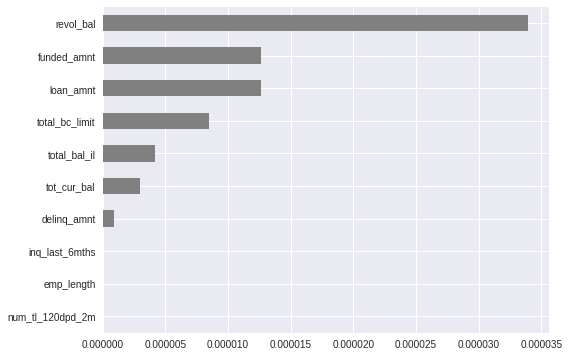

In [27]:
#How do Linear or Regression model think
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier
import matplotlib.pyplot as plt

encoder = ce.OrdinalEncoder()
X = encoder.fit_transform(X_train)

lr = LogisticRegression(solver='lbfgs')
lr.fit(X,y)
lr_pred = lr.predict(X_val)

rf = RandomForestClassifier()
rf.fit(X_train, y_train)
rf_pred_proba = rf.predict_proba(X_val)[:,1]

gb = GradientBoostingClassifier()
gb.fit(X_train, y_train)
gb_pred_proba = gb.predict_proba(X_val)[:,1]

print('LogisticRegression Accuracy:', accuracy(y_val, lr_pred))
print('RandomForest ROC AUC:', roc_auc_score(y_val, rf_pred_proba))
print('GradientBoosting ROC AUC:', roc_auc_score(y_val, gb_pred_proba))



In [0]:
feature_importances = pd.Series(lr.coef_[0], X.columns)
top_10 = feature_importances.sort_values(ascending=False)[:10]
plt.figure(figsize=(8, 6))
top_10.sort_values().plot.barh(color='grey')

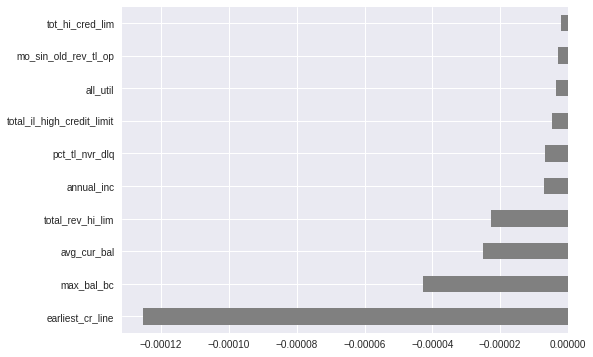

In [26]:
feature_importances = pd.Series(lr.coef_[0], X.columns)
lower_10 = feature_importances.sort_values()[:10]
plt.figure(figsize=(8, 6))
lower_10.sort_values().plot.barh(color='grey')


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


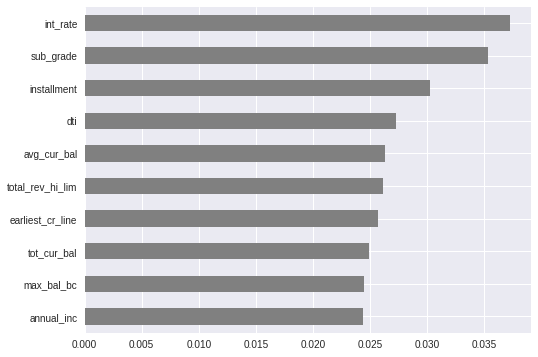

In [32]:
from sklearn.ensemble import RandomForestClassifier

encoder = ce.OrdinalEncoder()
X = encoder.fit_transform(X_train)

rf = RandomForestClassifier()
rf.fit(X, y)

importances = pd.Series(rf.feature_importances_, X.columns)
top_n = importances.sort_values(ascending=False)[:10]
plt.figure(figsize=(8, 6))
top_n.sort_values().plot.barh(color='grey')

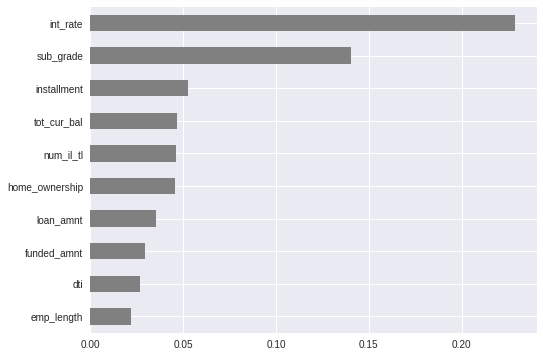

In [30]:
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier

encoder = ce.OrdinalEncoder()
X = encoder.fit_transform(X_train)

gb = GradientBoostingClassifier()
gb.fit(X, y)

importances = pd.Series(gb.feature_importances_, X.columns)
top_n = importances.sort_values(ascending=False)[:10]
plt.figure(figsize=(8, 6))
top_n.sort_values().plot.barh(color='grey')